
██████████████████████████████████████████████████████████████████████
█                                                                    █
█     ENHANCED BATEMAN EQUATION SOLVER FOR NUCLEAR DECAY CHAINS      █
█                                                                    █
██████████████████████████████████████████████████████████████████████


EXAMPLE 1: Uranium-238 Decay Series

Decay Chain: U-238 Decay Series

Nuclides (5):
  [0] U-238        | λ=4.916e-18 | T½=1.410e+17 | N₀=1.000e+10
  [1] Th-234       | λ=3.332e-07 | T½=2.080e+06 | N₀=0.000e+00
  [2] Pa-234m      | λ=9.874e-03 | T½=7.020e+01 | N₀=0.000e+00
  [3] U-234        | λ=8.944e-14 | T½=7.750e+12 | N₀=0.000e+00
  [4] Th-230       | λ=2.912e-13 | T½=2.380e+12 | N₀=0.000e+00

Decay Transitions (4):
  U-238        → Th-234       (BR=1.000)
  Th-234       → Pa-234m      (BR=1.000)
  Pa-234m      → U-234        (BR=1.000)
  U-234        → Th-230       (BR=1.000)

Results after 10 years:
  U-238     : 1.0000e+10 atoms

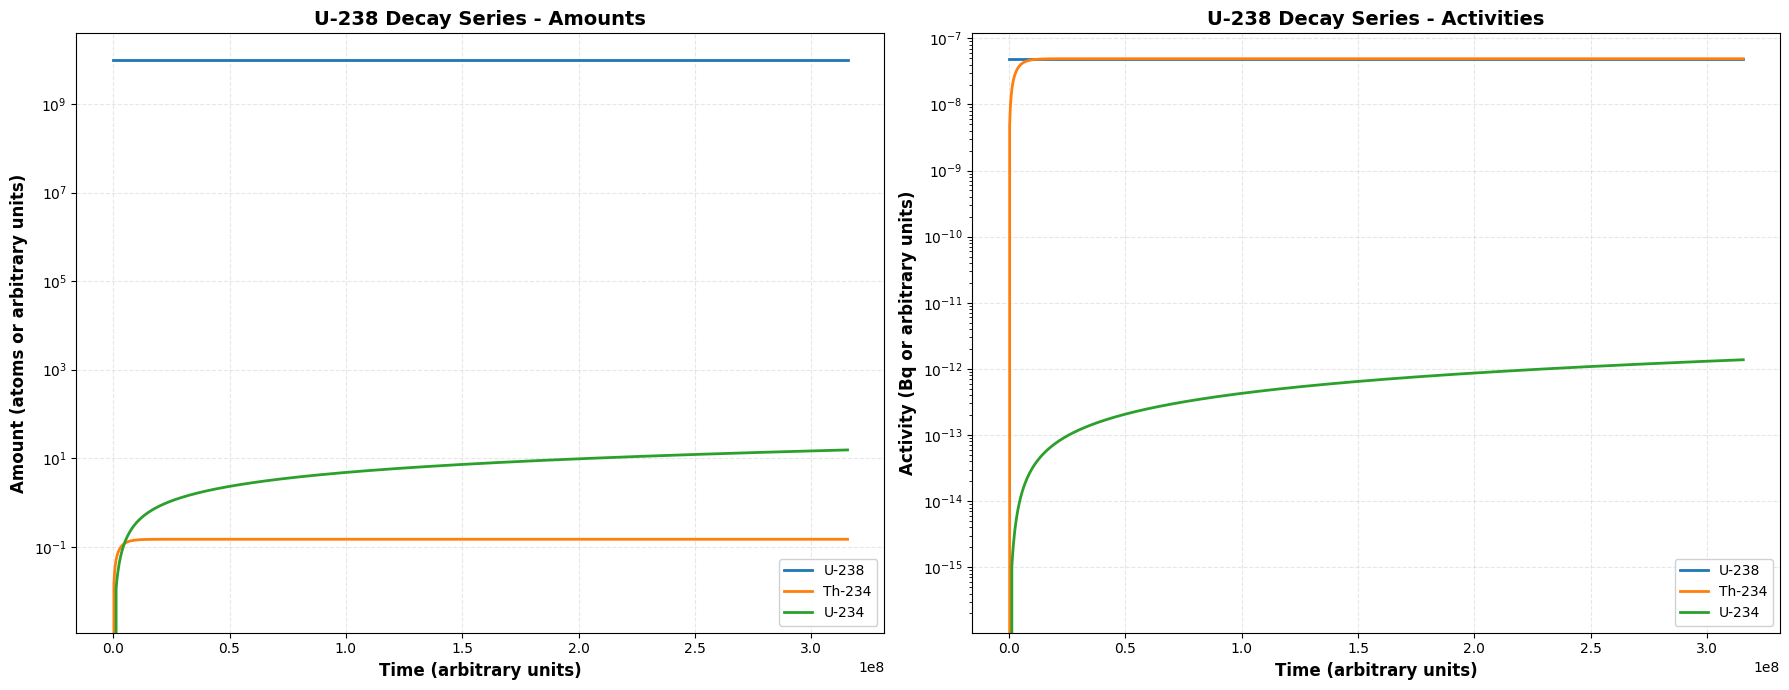


EXAMPLE 2: Mo-99/Tc-99m Medical Isotope Generator

Decay Chain: Mo-99/Tc-99m Generator

Nuclides (3):
  [0] Mo-99        | λ=2.917e-06 | T½=2.376e+05 | N₀=1.000e+12
  [1] Tc-99m       | λ=3.204e-05 | T½=2.164e+04 | N₀=0.000e+00
  [2] Tc-99        | λ=1.050e-13 | T½=6.600e+12 | N₀=0.000e+00

Decay Transitions (3):
  Mo-99        → Tc-99m       (BR=0.876)
  Mo-99        → Tc-99        (BR=0.124)
  Tc-99m       → Tc-99        (BR=1.000)



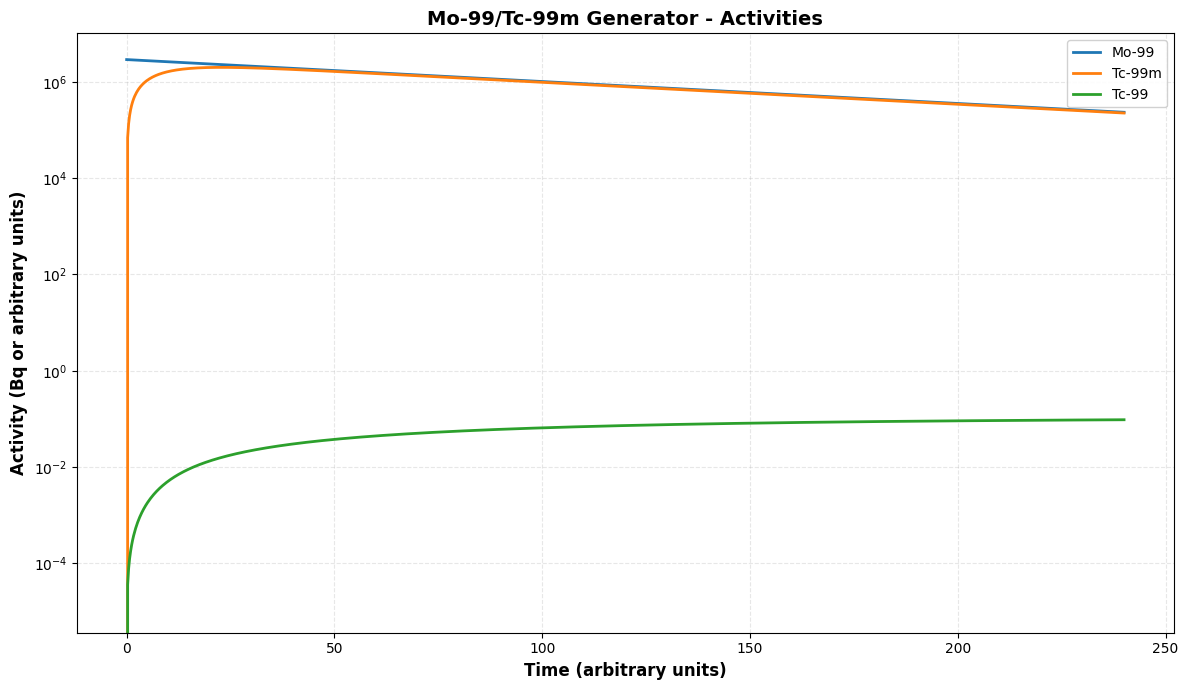


EXAMPLE 3: Complex Branching Decay Network

Decay Chain: Complex Branching Network

Nuclides (6):
  [0] A            | λ=6.931e-02 | T½=1.000e+01 | N₀=1.000e+03
  [1] B            | λ=3.466e-02 | T½=2.000e+01 | N₀=0.000e+00
  [2] C            | λ=4.621e-02 | T½=1.500e+01 | N₀=0.000e+00
  [3] D            | λ=1.386e-01 | T½=5.000e+00 | N₀=0.000e+00
  [4] E            | λ=2.310e-02 | T½=3.000e+01 | N₀=0.000e+00
  [5] Stable       | λ=0.000e+00 | T½=inf | N₀=0.000e+00

Decay Transitions (7):
  A            → B            (BR=0.600)
  A            → C            (BR=0.400)
  B            → D            (BR=0.800)
  B            → E            (BR=0.200)
  C            → D            (BR=1.000)
  D            → Stable       (BR=1.000)
  E            → Stable       (BR=1.000)



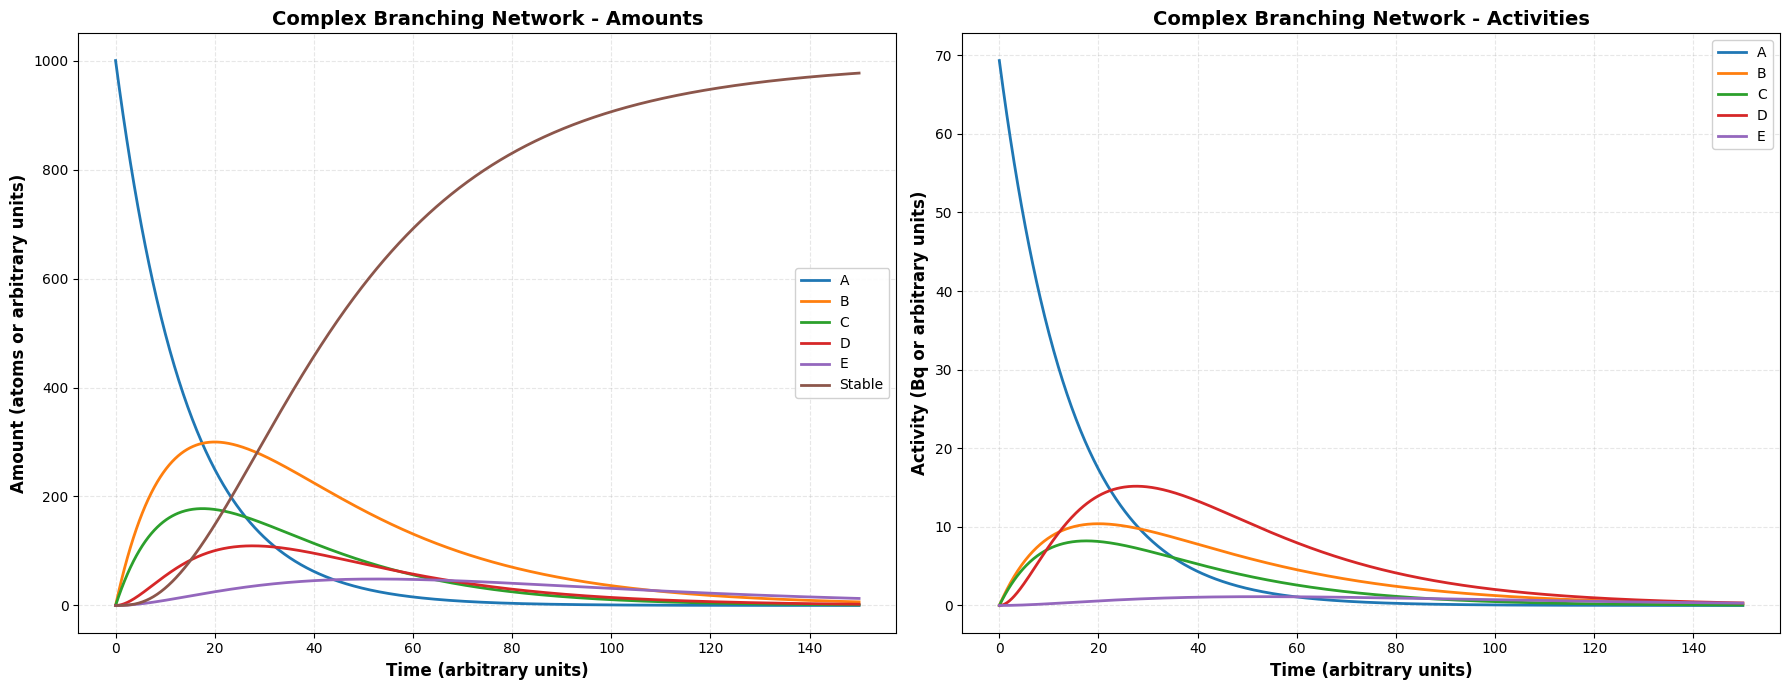


Enhanced Bateman Equation Solver - Ready!


In [1]:
"""
Enhanced Bateman Equation Solver for Nuclear Decay Chains
Solves complex radioactive decay chains with improved numerics and features
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Union
from dataclasses import dataclass
from enum import Enum
import warnings

class TimeUnit(Enum):
    """Standard time units with conversion factors to seconds"""
    SECONDS = 1.0
    MINUTES = 60.0
    HOURS = 3600.0
    DAYS = 86400.0
    YEARS = 31557600.0  # Julian year

@dataclass
class NuclideData:
    """Represents a single nuclide in the decay chain"""
    name: str
    decay_constant: float  # 1/time unit
    initial_amount: float = 0.0
    
    @property
    def half_life(self) -> float:
        """Calculate half-life from decay constant"""
        return np.log(2) / self.decay_constant if self.decay_constant > 0 else np.inf
    
    @classmethod
    def from_half_life(cls, name: str, half_life: float, initial_amount: float = 0.0):
        """Create nuclide from half-life instead of decay constant"""
        if half_life <= 0:
            raise ValueError("Half-life must be positive")
        decay_constant = np.log(2) / half_life
        return cls(name, decay_constant, initial_amount)
    
    def __repr__(self):
        return f"NuclideData('{self.name}', λ={self.decay_constant:.3e}, N₀={self.initial_amount:.3e})"

class DecayChain:
    """Represents a complete radioactive decay chain with validation"""
    
    def __init__(self, name: str = "Decay Chain"):
        self.name = name
        self.nuclides: List[NuclideData] = []
        self.transitions: List[Tuple[int, int, float]] = []
        self.nuclide_map: Dict[str, int] = {}
    
    def add_nuclide(self, name: str, decay_constant: float = None, 
                    half_life: float = None, initial_amount: float = 0.0) -> int:
        """
        Add a nuclide to the decay chain
        
        Parameters:
        -----------
        name : str
            Name/symbol of the nuclide
        decay_constant : float, optional
            Decay constant (1/time unit)
        half_life : float, optional
            Half-life (in same time units). Alternative to decay_constant
        initial_amount : float
            Initial amount/activity at t=0
        """
        if name in self.nuclide_map:
            raise ValueError(f"Nuclide '{name}' already exists in chain")
        
        if decay_constant is None and half_life is None:
            raise ValueError("Must provide either decay_constant or half_life")
        
        if decay_constant is not None and half_life is not None:
            raise ValueError("Cannot provide both decay_constant and half_life")
        
        idx = len(self.nuclides)
        self.nuclide_map[name] = idx
        
        if half_life is not None:
            nuclide = NuclideData.from_half_life(name, half_life, initial_amount)
        else:
            nuclide = NuclideData(name, decay_constant, initial_amount)
        
        self.nuclides.append(nuclide)
        return idx
    
    def add_decay(self, parent: str, daughter: str, branching_ratio: float = 1.0):
        """Add a decay transition from parent to daughter with validation"""
        if parent not in self.nuclide_map:
            raise ValueError(f"Parent nuclide '{parent}' not found")
        if daughter not in self.nuclide_map:
            raise ValueError(f"Daughter nuclide '{daughter}' not found")
        
        parent_idx = self.nuclide_map[parent]
        daughter_idx = self.nuclide_map[daughter]
        
        if parent_idx == daughter_idx:
            raise ValueError("Parent and daughter cannot be the same nuclide")
        
        if not 0 < branching_ratio <= 1:
            raise ValueError("Branching ratio must be in (0, 1]")
        
        self.transitions.append((parent_idx, daughter_idx, branching_ratio))
    
    def validate(self) -> List[str]:
        """Validate decay chain and return warnings"""
        warnings_list = []
        
        # Check total branching ratios
        parent_br = {}
        for parent_idx, _, br in self.transitions:
            parent_br[parent_idx] = parent_br.get(parent_idx, 0) + br
        
        for idx, total_br in parent_br.items():
            if total_br > 1.0001:  # Small tolerance for floating point
                warnings_list.append(
                    f"Nuclide '{self.nuclides[idx].name}' has total branching ratio {total_br:.4f} > 1.0"
                )
        
        # Check for cycles
        if self._has_cycle():
            warnings_list.append("Decay chain contains a cycle (non-physical)")
        
        # Check for disconnected nuclides
        connected = self._get_connected_nuclides()
        for i, nuclide in enumerate(self.nuclides):
            if i not in connected and nuclide.initial_amount == 0:
                warnings_list.append(
                    f"Nuclide '{nuclide.name}' is disconnected from the chain and has zero initial amount"
                )
        
        return warnings_list
    
    def _has_cycle(self) -> bool:
        """Check for cycles in the decay chain using DFS"""
        n = len(self.nuclides)
        graph = {i: [] for i in range(n)}
        for parent, daughter, _ in self.transitions:
            graph[parent].append(daughter)
        
        visited = [False] * n
        rec_stack = [False] * n
        
        def dfs(node):
            visited[node] = True
            rec_stack[node] = True
            
            for neighbor in graph[node]:
                if not visited[neighbor]:
                    if dfs(neighbor):
                        return True
                elif rec_stack[neighbor]:
                    return True
            
            rec_stack[node] = False
            return False
        
        for node in range(n):
            if not visited[node]:
                if dfs(node):
                    return True
        return False
    
    def _get_connected_nuclides(self) -> set:
        """Get set of all nuclides connected to initial amounts"""
        connected = set()
        
        # Start with nuclides that have initial amounts
        to_visit = [i for i, n in enumerate(self.nuclides) if n.initial_amount > 0]
        connected.update(to_visit)
        
        # BFS to find all connected nuclides
        while to_visit:
            current = to_visit.pop(0)
            for parent, daughter, _ in self.transitions:
                if parent == current and daughter not in connected:
                    connected.add(daughter)
                    to_visit.append(daughter)
        
        return connected
    
    def get_decay_matrix(self) -> np.ndarray:
        """Construct the decay matrix A for dN/dt = A*N"""
        n = len(self.nuclides)
        A = np.zeros((n, n))
        
        # Diagonal: -λᵢ (loss by decay)
        for i, nuclide in enumerate(self.nuclides):
            A[i, i] = -nuclide.decay_constant
        
        # Off-diagonal: λⱼ * BRⱼᵢ (gain from parent decay)
        for parent_idx, daughter_idx, br in self.transitions:
            lambda_parent = self.nuclides[parent_idx].decay_constant
            A[daughter_idx, parent_idx] += lambda_parent * br
        
        return A
    
    def get_initial_vector(self) -> np.ndarray:
        """Get initial amounts vector"""
        return np.array([n.initial_amount for n in self.nuclides])
    
    def print_summary(self):
        """Print a summary of the decay chain"""
        print(f"\n{'='*60}")
        print(f"Decay Chain: {self.name}")
        print(f"{'='*60}")
        print(f"\nNuclides ({len(self.nuclides)}):")
        for i, nuc in enumerate(self.nuclides):
            print(f"  [{i}] {nuc.name:12s} | λ={nuc.decay_constant:.3e} | "
                  f"T½={nuc.half_life:.3e} | N₀={nuc.initial_amount:.3e}")
        
        print(f"\nDecay Transitions ({len(self.transitions)}):")
        for parent_idx, daughter_idx, br in self.transitions:
            parent = self.nuclides[parent_idx].name
            daughter = self.nuclides[daughter_idx].name
            print(f"  {parent:12s} → {daughter:12s} (BR={br:.3f})")
        
        warnings_list = self.validate()
        if warnings_list:
            print(f"\n⚠️  Warnings:")
            for w in warnings_list:
                print(f"  • {w}")
        print(f"{'='*60}\n")

class BatemanSolver:
    """Enhanced solver for Bateman equations with multiple methods"""
    
    def __init__(self, decay_chain: DecayChain, validate: bool = True):
        self.chain = decay_chain
        self.A = decay_chain.get_decay_matrix()
        self.N0 = decay_chain.get_initial_vector()
        
        if validate:
            warnings_list = decay_chain.validate()
            for w in warnings_list:
                warnings.warn(w)
    
    def solve_matrix_exponential(self, t: np.ndarray, rtol: float = 1e-12) -> np.ndarray:
        """
        Solve using matrix exponential: N(t) = exp(A*t) * N₀
        Most accurate for short to medium chains
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        rtol : float
            Relative tolerance for near-zero values
        """
        results = np.zeros((len(t), len(self.N0)))
        
        for i, time in enumerate(t):
            results[i] = expm(self.A * time) @ self.N0
            # Clean up near-zero values for numerical stability
            results[i][np.abs(results[i]) < rtol * np.max(np.abs(results[i]))] = 0
        
        return np.maximum(results, 0)  # Ensure non-negative
    
    def solve_ode(self, t: np.ndarray, method: str = 'LSODA', 
                  rtol: float = 1e-9, atol: float = 1e-12) -> np.ndarray:
        """
        Solve using adaptive ODE integration (solve_ivp)
        Best for stiff systems and long chains
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        method : str
            Integration method: 'LSODA', 'Radau', 'BDF', 'RK45', 'RK23'
        rtol, atol : float
            Relative and absolute tolerances
        """
        def derivative(t, N):
            return self.A @ N
        
        solution = solve_ivp(
            derivative, 
            (t[0], t[-1]), 
            self.N0, 
            method=method,
            t_eval=t,
            rtol=rtol,
            atol=atol,
            dense_output=False
        )
        
        if not solution.success:
            warnings.warn(f"ODE solver warning: {solution.message}")
        
        return np.maximum(solution.y.T, 0)  # Ensure non-negative
    
    def solve(self, t: np.ndarray, method: str = 'auto', **kwargs) -> np.ndarray:
        """
        Solve the decay chain with automatic method selection
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        method : str
            'auto', 'matrix_exp', 'ode', or specific ODE method
        **kwargs : dict
            Additional arguments for solver methods
        
        Returns:
        --------
        np.ndarray
            Array of shape (len(t), n_nuclides) with amounts at each time
        """
        if method == 'auto':
            # Auto-select based on chain size and stiffness
            n = len(self.chain.nuclides)
            lambdas = [nuc.decay_constant for nuc in self.chain.nuclides]
            
            if n <= 15:
                method = 'matrix_exp'
            else:
                # Check stiffness ratio
                lambda_max = max(lambdas) if lambdas else 1
                lambda_min = min([l for l in lambdas if l > 0], default=1)
                stiffness_ratio = lambda_max / lambda_min if lambda_min > 0 else 1
                
                if stiffness_ratio > 1e6:
                    method = 'LSODA'  # Good for stiff systems
                else:
                    method = 'RK45'
        
        if method == 'matrix_exp':
            return self.solve_matrix_exponential(t, **kwargs)
        elif method in ['ode', 'LSODA', 'Radau', 'BDF', 'RK45', 'RK23', 'DOP853']:
            ode_method = kwargs.pop('ode_method', method if method != 'ode' else 'LSODA')
            return self.solve_ode(t, method=ode_method, **kwargs)
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def get_activities(self, amounts: np.ndarray) -> np.ndarray:
        """Convert amounts to activities: A = λ * N"""
        lambdas = np.array([n.decay_constant for n in self.chain.nuclides])
        return amounts * lambdas[np.newaxis, :]
    
    def find_equilibrium_time(self, nuclide_name: str, tolerance: float = 0.01) -> Optional[float]:
        """
        Find time when secular/transient equilibrium is reached
        
        Parameters:
        -----------
        nuclide_name : str
            Name of daughter nuclide
        tolerance : float
            Relative tolerance for equilibrium (default 1%)
        """
        if nuclide_name not in self.chain.nuclide_map:
            raise ValueError(f"Nuclide '{nuclide_name}' not found")
        
        idx = self.chain.nuclide_map[nuclide_name]
        lambda_d = self.chain.nuclides[idx].decay_constant
        
        if lambda_d == 0:
            return None  # Stable nuclide
        
        # Estimate: ~5-7 daughter half-lives
        t_est = 7 * np.log(2) / lambda_d
        t = np.linspace(0, t_est * 2, 1000)
        
        amounts = self.solve(t)
        activities = self.get_activities(amounts)
        
        # Find parent(s)
        parent_indices = [p for p, d, _ in self.chain.transitions if d == idx]
        if not parent_indices:
            return None
        
        # Check ratio of activities
        for i in range(len(t) - 1, 0, -1):
            parent_act = sum(activities[i, p] for p in parent_indices)
            daughter_act = activities[i, idx]
            
            if parent_act > 0 and daughter_act > 0:
                ratio = abs(daughter_act / parent_act - 1)
                if ratio < tolerance:
                    return t[i]
        
        return None
    
    def plot_results(self, t: np.ndarray, amounts: np.ndarray, 
                     plot_type: str = 'amounts', log_scale: bool = True,
                     nuclides: Optional[List[str]] = None,
                     filename: Optional[str] = None,
                     figsize: Tuple[float, float] = (12, 7),
                     dpi: int = 100):
        """
        Create enhanced visualization of decay chain results
        
        Parameters:
        -----------
        t : np.ndarray
            Time points
        amounts : np.ndarray
            Amounts array from solve()
        plot_type : str
            'amounts', 'activities', or 'both'
        log_scale : bool
            Use logarithmic y-axis
        nuclides : List[str], optional
            Specific nuclides to plot (default: all)
        filename : str, optional
            Save plot to file
        figsize : Tuple[float, float]
            Figure size
        dpi : int
            Resolution for saved figure
        """
        if plot_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
            axes = [ax1, ax2]
            plot_types = ['amounts', 'activities']
        else:
            fig, ax = plt.subplots(figsize=figsize)
            axes = [ax]
            plot_types = [plot_type]
        
        for ax, ptype in zip(axes, plot_types):
            if ptype == 'activities':
                data = self.get_activities(amounts)
                ylabel = 'Activity (Bq or arbitrary units)'
            else:
                data = amounts
                ylabel = 'Amount (atoms or arbitrary units)'
            
            # Determine which nuclides to plot
            if nuclides:
                indices = [self.chain.nuclide_map[name] for name in nuclides]
            else:
                # Plot all nuclides with non-zero values
                indices = [i for i in range(len(self.chain.nuclides)) 
                          if np.max(data[:, i]) > 0]
            
            # Use color cycle
            colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(indices))))
            
            for i, idx in enumerate(indices):
                nuclide = self.chain.nuclides[idx]
                ax.plot(t, data[:, idx], label=nuclide.name, 
                       linewidth=2, color=colors[i % len(colors)])
            
            ax.set_xlabel('Time (arbitrary units)', fontsize=12, fontweight='bold')
            ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
            ax.set_title(f'{self.chain.name} - {ptype.capitalize()}', 
                        fontsize=14, fontweight='bold')
            ax.legend(loc='best', framealpha=0.9)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            if log_scale:
                ax.set_yscale('log')
                # Set lower limit to avoid log(0)
                min_val = np.min(data[data > 0]) if np.any(data > 0) else 1e-10
                ax.set_ylim(bottom=min_val * 0.1)
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight')
            print(f"Plot saved to: {filename}")
        
        plt.show()

# Enhanced Examples
def example_uranium_series():
    """Enhanced U-238 decay series with realistic constants"""
    print("\n" + "="*70)
    print("EXAMPLE 1: Uranium-238 Decay Series")
    print("="*70)
    
    chain = DecayChain("U-238 Decay Series")
    
    # More complete chain with realistic half-lives
    chain.add_nuclide("U-238", half_life=1.41e17, initial_amount=1e10)  # 4.47e9 years in seconds
    chain.add_nuclide("Th-234", half_life=2.08e6)   # 24.1 days in seconds
    chain.add_nuclide("Pa-234m", half_life=70.2)     # 1.17 minutes in seconds
    chain.add_nuclide("U-234", half_life=7.75e12)    # 245,500 years in seconds
    chain.add_nuclide("Th-230", half_life=2.38e12)   # 75,380 years in seconds
    
    chain.add_decay("U-238", "Th-234")
    chain.add_decay("Th-234", "Pa-234m")
    chain.add_decay("Pa-234m", "U-234")
    chain.add_decay("U-234", "Th-230")
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    # Solve over 10 years (in seconds)
    t = np.linspace(0, 10 * 365.25 * 86400, 1000)
    amounts = solver.solve(t, method='matrix_exp')
    
    print("Results after 10 years:")
    for i, nuc in enumerate(chain.nuclides):
        print(f"  {nuc.name:10s}: {amounts[-1, i]:.4e} atoms")
    
    solver.plot_results(t, amounts, plot_type='both', log_scale=True)
    
    return chain, solver

def example_medical_isotope():
    """Example: Mo-99/Tc-99m generator (medical isotope production)"""
    print("\n" + "="*70)
    print("EXAMPLE 2: Mo-99/Tc-99m Medical Isotope Generator")
    print("="*70)
    
    chain = DecayChain("Mo-99/Tc-99m Generator")
    
    # Mo-99 -> Tc-99m -> Tc-99 (stable for practical purposes)
    chain.add_nuclide("Mo-99", half_life=66*3600, initial_amount=1e12)    # 66 hours
    chain.add_nuclide("Tc-99m", half_life=6.01*3600, initial_amount=0)    # 6.01 hours
    chain.add_nuclide("Tc-99", half_life=6.6e12, initial_amount=0)        # Very long (211,000 years)
    
    chain.add_decay("Mo-99", "Tc-99m", branching_ratio=0.876)
    chain.add_decay("Mo-99", "Tc-99", branching_ratio=0.124)
    chain.add_decay("Tc-99m", "Tc-99")
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    # Solve over 10 days
    t = np.linspace(0, 10*24*3600, 1000)
    amounts = solver.solve(t)
    activities = solver.get_activities(amounts)
    
    # Find transient equilibrium time
    eq_time = solver.find_equilibrium_time("Tc-99m")
    if eq_time:
        print(f"Transient equilibrium reached at: {eq_time/3600:.2f} hours")
    
    solver.plot_results(t/3600, amounts, plot_type='activities', log_scale=True)
    
    return chain, solver

def example_branching_complex():
    """Example: Complex branching decay"""
    print("\n" + "="*70)
    print("EXAMPLE 3: Complex Branching Decay Network")
    print("="*70)
    
    chain = DecayChain("Complex Branching Network")
    
    chain.add_nuclide("A", half_life=10, initial_amount=1000)
    chain.add_nuclide("B", half_life=20, initial_amount=0)
    chain.add_nuclide("C", half_life=15, initial_amount=0)
    chain.add_nuclide("D", half_life=5, initial_amount=0)
    chain.add_nuclide("E", half_life=30, initial_amount=0)
    chain.add_nuclide("Stable", decay_constant=0, initial_amount=0)
    
    chain.add_decay("A", "B", branching_ratio=0.6)
    chain.add_decay("A", "C", branching_ratio=0.4)
    chain.add_decay("B", "D", branching_ratio=0.8)
    chain.add_decay("B", "E", branching_ratio=0.2)
    chain.add_decay("C", "D", branching_ratio=1.0)
    chain.add_decay("D", "Stable", branching_ratio=1.0)
    chain.add_decay("E", "Stable", branching_ratio=1.0)
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    t = np.linspace(0, 150, 1000)
    amounts = solver.solve(t, method='auto')
    
    solver.plot_results(t, amounts, plot_type='both', log_scale=False)
    
    return chain, solver

if __name__ == "__main__":
    print("\n" + "█"*70)
    print("█" + " "*68 + "█")
    print("█" + "  ENHANCED BATEMAN EQUATION SOLVER FOR NUCLEAR DECAY CHAINS  ".center(68) + "█")
    print("█" + " "*68 + "█")
    print("█"*70 + "\n")
    
    # Run enhanced examples
    example_uranium_series()
    example_medical_isotope()
    example_branching_complex()
    
    print("\n" + "="*70)
    print("Enhanced Bateman Equation Solver - Ready!")
    print("="*70)